<a href="https://colab.research.google.com/github/afeef2003/task-8/blob/main/task_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages (if not already installed)
!pip install yfinance scikit-learn pandas numpy matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=" * 60)
print("TASK 8: MODEL EVALUATION METRICS")
print("Amazon Stock Price Movement Prediction")
print("=" * 60)

TASK 8: MODEL EVALUATION METRICS
Amazon Stock Price Movement Prediction


In [ ]:
# Step 1: Load Amazon Stock Data
print("\n1. LOADING AMAZON STOCK DATA")
print("-" * 40)

# Option 1: Download from Yahoo Finance (Automatic - Recommended)
# end_date = datetime.now()
# start_date = end_date - timedelta(days=730)  # 2 years of data
# ticker = "AMZN"
# amazon_data = yf.download(ticker, start=start_date, end=end_date)

# Option 2: Load from your own CSV file (Uncomment if you have a CSV file)
amazon_data = pd.read_csv('/content/AMZN_stock_data.csv', index_col=0, parse_dates=True)
# Make sure your CSV has columns: Open, High, Low, Close, Volume

# Option 3: Upload file in Google Colab (Uncomment if you want to upload)
# from google.colab import files
# uploaded = files.upload()
# amazon_data = pd.read_csv(list(uploaded.keys())[0], index_col=0, parse_dates=True)

print(f"Loaded {len(amazon_data)} days of Amazon stock data")
print(f"Dataset shape: {amazon_data.shape}")
print("\nColumn names:", amazon_data.columns.tolist())
print("\nFirst 5 rows:")
print(amazon_data.head())


1. LOADING AMAZON STOCK DATA
----------------------------------------
Loaded 6987 days of Amazon stock data
Dataset shape: (6987, 7)

Column names: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

First 5 rows:
                               Open      High       Low     Close      Volume  \
Date                                                                            
1997-05-15 00:00:00-04:00  0.121875  0.125000  0.096354  0.097917  1443120000   
1997-05-16 00:00:00-04:00  0.098438  0.098958  0.085417  0.086458   294000000   
1997-05-19 00:00:00-04:00  0.088021  0.088542  0.081250  0.085417   122136000   
1997-05-20 00:00:00-04:00  0.086458  0.087500  0.081771  0.081771   109344000   
1997-05-21 00:00:00-04:00  0.081771  0.082292  0.068750  0.071354   377064000   

                           Dividends  Stock Splits  
Date                                                
1997-05-15 00:00:00-04:00        0.0           0.0  
1997-05-16 00:00:00-04:00        0.0 

In [ ]:
# Step 2: Feature Engineering
print("\n\n2. FEATURE ENGINEERING")
print("-" * 40)

# Create a copy for feature engineering
df = amazon_data.copy()

# Create technical indicators as features
df['Returns'] = df['Close'].pct_change()
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Volatility'] = df['Returns'].rolling(window=20).std()
df['Volume_MA'] = df['Volume'].rolling(window=10).mean()

# Create price-based features
df['High_Low_Ratio'] = df['High'] / df['Low']
df['Price_Volume'] = df['Close'] * df['Volume']
df['Upper_Shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
df['Lower_Shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']

# Create lagged features
df['Returns_Lag1'] = df['Returns'].shift(1)
df['Returns_Lag2'] = df['Returns'].shift(2)
df['Volume_Lag1'] = df['Volume'].shift(1)

# Create target variable: 1 if next day's price goes up, 0 if it goes down
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Remove rows with NaN values
df = df.dropna()

print(f"Features created successfully!")
print(f"Dataset shape after feature engineering: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['Target'].value_counts())



2. FEATURE ENGINEERING
----------------------------------------
Features created successfully!
Dataset shape after feature engineering: (6967, 20)

Target variable distribution:
Target
1    3550
0    3417
Name: count, dtype: int64


In [ ]:
# Step 3: Prepare Features and Target
print("\n\n3. PREPARING FEATURES AND TARGET")
print("-" * 40)

# Select features for the model
feature_columns = [
    'Returns', 'MA_5', 'MA_20', 'Volatility', 'Volume_MA',
    'High_Low_Ratio', 'Price_Volume', 'Upper_Shadow', 'Lower_Shadow',
    'Returns_Lag1', 'Returns_Lag2', 'Volume_Lag1'
]

X = df[feature_columns]
y = df['Target']

print(f"Features selected: {len(feature_columns)}")
print("Feature list:")
for i, feature in enumerate(feature_columns, 1):
    print(f"  {i}. {feature}")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")



3. PREPARING FEATURES AND TARGET
----------------------------------------
Features selected: 12
Feature list:
  1. Returns
  2. MA_5
  3. MA_20
  4. Volatility
  5. Volume_MA
  6. High_Low_Ratio
  7. Price_Volume
  8. Upper_Shadow
  9. Lower_Shadow
  10. Returns_Lag1
  11. Returns_Lag2
  12. Volume_Lag1

Feature matrix shape: (6967, 12)
Target vector shape: (6967,)


In [ ]:
# Step 4: Split the Data
print("\n\n4. SPLITTING THE DATA")
print("-" * 40)

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set target distribution: {y_train.value_counts().to_dict()}")
print(f"Testing set target distribution: {y_test.value_counts().to_dict()}")



4. SPLITTING THE DATA
----------------------------------------
Training set size: 5573 samples
Testing set size: 1394 samples
Training set target distribution: {1: 2840, 0: 2733}
Testing set target distribution: {1: 710, 0: 684}


In [ ]:
# Step 5: Feature Scaling
print("\n\n5. FEATURE SCALING")
print("-" * 40)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized using StandardScaler")
print(f"Training features mean: {np.mean(X_train_scaled, axis=0)[:3]}... (first 3 features)")
print(f"Training features std: {np.std(X_train_scaled, axis=0)[:3]}... (first 3 features)")



5. FEATURE SCALING
----------------------------------------
Features standardized using StandardScaler
Training features mean: [ 8.92481455e-18 -3.44242847e-17 -1.27497351e-17]... (first 3 features)
Training features std: [1. 1. 1.]... (first 3 features)


In [ ]:
# Step 6: Train Logistic Regression Model
print("\n\n6. TRAINING LOGISTIC REGRESSION MODEL")
print("-" * 40)

# Initialize and train the model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully!")
print(f"Model coefficients shape: {lr_model.coef_.shape}")

# Display feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())



6. TRAINING LOGISTIC REGRESSION MODEL
----------------------------------------
Logistic Regression model trained successfully!
Model coefficients shape: (1, 12)

Top 5 Most Important Features:
        Feature  Coefficient  Abs_Coefficient
2         MA_20     0.395902         0.395902
1          MA_5    -0.374673         0.374673
7  Upper_Shadow     0.081249         0.081249
3    Volatility    -0.078553         0.078553
8  Lower_Shadow    -0.068225         0.068225


In [ ]:
# Step 7: Make Predictions
print("\n\n7. MAKING PREDICTIONS")
print("-" * 40)

# Make predictions on test set
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions completed!")
print(f"Predictions shape: {y_pred.shape}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

# Preview predictions
predictions_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10],
    'Probability': y_pred_proba[:10]
})
print("\nFirst 10 predictions:")
print(predictions_df)



7. MAKING PREDICTIONS
----------------------------------------
Predictions completed!
Predictions shape: (1394,)
Prediction probabilities shape: (1394,)

First 10 predictions:
   Actual  Predicted  Probability
0       0          1     0.501331
1       0          0     0.496377
2       1          1     0.502486
3       1          1     0.523130
4       1          1     0.508649
5       0          0     0.495584
6       0          1     0.501113
7       0          1     0.607423
8       1          1     0.527023
9       0          1     0.519651


In [ ]:
# Step 8: Calculate Evaluation Metrics
print("\n\n8. CALCULATING EVALUATION METRICS")
print("=" * 50)

# Calculate main metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ACCURACY:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"PRECISION: {precision:.4f}")
print(f"RECALL:    {recall:.4f}")
print(f"F1-SCORE:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")



8. CALCULATING EVALUATION METRICS
ACCURACY:  0.5308 (53.08%)
PRECISION: 0.5285
RECALL:    0.7310
F1-SCORE:  0.6135
ROC AUC:   0.5320


In [ ]:
# Step 9: Detailed Classification Report
print("\n\n9. DETAILED CLASSIFICATION REPORT")
print("-" * 50)
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))



9. DETAILED CLASSIFICATION REPORT
--------------------------------------------------
              precision    recall  f1-score   support

        Down       0.54      0.32      0.40       684
          Up       0.53      0.73      0.61       710

    accuracy                           0.53      1394
   macro avg       0.53      0.53      0.51      1394
weighted avg       0.53      0.53      0.51      1394



In [ ]:
# Step 10: Confusion Matrix
print("\n\n10. CONFUSION MATRIX")
print("-" * 30)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nBreakdown:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

# Calculate metrics manually for verification
manual_accuracy = (tp + tn) / (tp + tn + fp + fn)
manual_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
manual_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
manual_f1 = 2 * (manual_precision * manual_recall) / (manual_precision + manual_recall) if (manual_precision + manual_recall) > 0 else 0

print(f"\nManual Verification:")
print(f"Manual Accuracy:  {manual_accuracy:.4f}")
print(f"Manual Precision: {manual_precision:.4f}")
print(f"Manual Recall:    {manual_recall:.4f}")
print(f"Manual F1-Score:  {manual_f1:.4f}")



10. CONFUSION MATRIX
------------------------------
Confusion Matrix:
[[221 463]
 [191 519]]

Breakdown:
True Negatives (TN):  221
False Positives (FP): 463
False Negatives (FN): 191
True Positives (TP):  519

Manual Verification:
Manual Accuracy:  0.5308
Manual Precision: 0.5285
Manual Recall:    0.7310
Manual F1-Score:  0.6135




11. CREATING VISUALIZATIONS
----------------------------------------


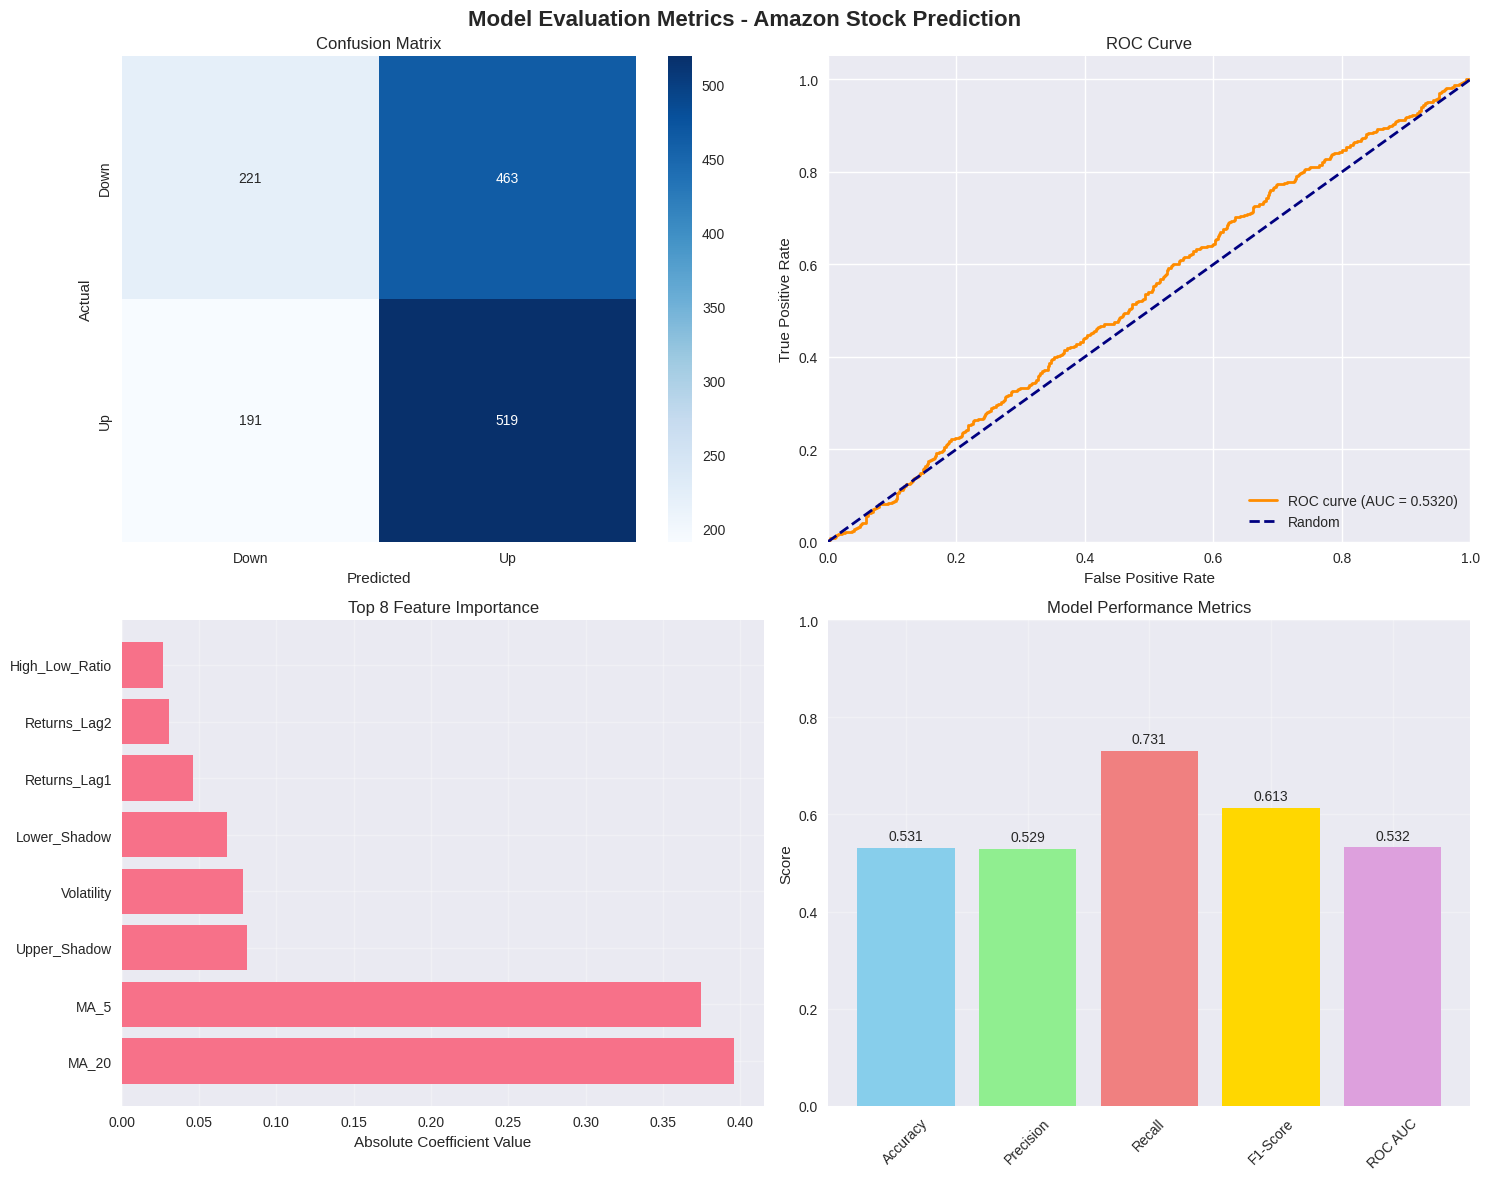

In [ ]:
# Step 11: Visualization
print("\n\n11. CREATING VISUALIZATIONS")
print("-" * 40)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Evaluation Metrics - Amazon Stock Prediction', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'],
            ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True)

# 3. Feature Importance
top_features = feature_importance.head(8)
axes[1, 0].barh(range(len(top_features)), top_features['Abs_Coefficient'])
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['Feature'])
axes[1, 0].set_xlabel('Absolute Coefficient Value')
axes[1, 0].set_title('Top 8 Feature Importance')
axes[1, 0].grid(True, alpha=0.3)

# 4. Metrics Comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']

bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_title('Model Performance Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Step 12: Interpretation and Discussion
print("\n\n12. METRIC INTERPRETATION AND DISCUSSION")
print("=" * 60)

print("\n🔍 ACCURACY INTERPRETATION:")
print(f"   • Accuracy = {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • This means the model correctly predicts stock direction {accuracy*100:.1f}% of the time")
print(f"   • Out of {len(y_test)} predictions, {int(accuracy * len(y_test))} were correct")

print(f"\n🎯 PRECISION INTERPRETATION:")
print(f"   • Precision = {precision:.4f}")
print(f"   • When the model predicts 'UP', it's correct {precision*100:.1f}% of the time")
print(f"   • Out of {tp + fp} 'UP' predictions, {tp} were actually correct")
print(f"   • High precision means fewer false alarms (false positives)")

print(f"\n📊 RECALL INTERPRETATION:")
print(f"   • Recall = {recall:.4f}")
print(f"   • The model identifies {recall*100:.1f}% of all actual 'UP' days")
print(f"   • Out of {tp + fn} actual 'UP' days, the model caught {tp}")
print(f"   • High recall means fewer missed opportunities (false negatives)")

print(f"\n⚖ F1-SCORE INTERPRETATION:")
print(f"   • F1-Score = {f1:.4f}")
print(f"   • Harmonic mean of precision and recall")
print(f"   • Balances both precision and recall")
print(f"   • Useful when you want to balance false positives and false negatives")

print(f"\n📈 ROC AUC INTERPRETATION:")
print(f"   • ROC AUC = {roc_auc:.4f}")
print(f"   • Measures the model's ability to distinguish between classes")
print(f"   • 0.5 = random guessing, 1.0 = perfect classifier")
print(f"   • Our model performs {'well' if roc_auc > 0.6 else 'moderately'} at distinguishing up vs down days")

print(f"\n💡 BUSINESS SIGNIFICANCE:")
if accuracy > 0.55:
    print("   ✅ Model shows promise for stock direction prediction")
    print("   ✅ Better than random guessing (50%)")
else:
    print("   ⚠  Model performance is close to random guessing")
    print("   ⚠  May need feature engineering or different approach")

print(f"\n🔧 MODEL INSIGHTS:")
print("   • Most important features for prediction:")
for i, row in feature_importance.head(3).iterrows():
    print(f"     - {row['Feature']}: {row['Coefficient']:.4f}")

print(f"\n📝 RECOMMENDATIONS:")
if precision > recall:
    print("   • Higher precision than recall - model is conservative")
    print("   • Good for risk-averse trading strategies")
    print("   • Consider lowering prediction threshold to increase recall")
elif recall > precision:
    print("   • Higher recall than precision - model is aggressive")
    print("   • Catches more opportunities but with more false signals")
    print("   • Consider raising prediction threshold to increase precision")
else:
    print("   • Balanced precision and recall")
    print("   • Good overall performance balance")

print(f"\n🎯 NEXT STEPS:")
print("   1. Try different algorithms (Random Forest, XGBoost)")
print("   2. Engineer more sophisticated features")
print("   3. Use cross-validation for robust evaluation")
print("   4. Consider ensemble methods")
print("   5. Implement backtesting for real-world validation")

print("\n" + "=" * 60)
print("MODEL EVALUATION COMPLETED SUCCESSFULLY!")
print("=" * 60)



12. METRIC INTERPRETATION AND DISCUSSION

🔍 ACCURACY INTERPRETATION:
   • Accuracy = 0.5308 (53.08%)
   • This means the model correctly predicts stock direction 53.1% of the time
   • Out of 1394 predictions, 740 were correct

🎯 PRECISION INTERPRETATION:
   • Precision = 0.5285
   • When the model predicts 'UP', it's correct 52.9% of the time
   • Out of 982 'UP' predictions, 519 were actually correct
   • High precision means fewer false alarms (false positives)

📊 RECALL INTERPRETATION:
   • Recall = 0.7310
   • The model identifies 73.1% of all actual 'UP' days
   • Out of 710 actual 'UP' days, the model caught 519
   • High recall means fewer missed opportunities (false negatives)

⚖ F1-SCORE INTERPRETATION:
   • F1-Score = 0.6135
   • Harmonic mean of precision and recall
   • Balances both precision and recall
   • Useful when you want to balance false positives and false negatives

📈 ROC AUC INTERPRETATION:
   • ROC AUC = 0.5320
   • Measures the model's ability to distinguis